# Sentinel-2 L2A Cloud Mask Time Series via Sentinel-Hub Process API

### _Import functional dependencies and add repository source directory to system path_

In [1]:
import os
import yaml
from munch import munchify

In [2]:
# define repo name and get root working directory
repo = 'process'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\apis\\process'

In [3]:
# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'sentinel-2' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\apis\\process\\cfg\\sentinel-2'

### _Load configuration file from repository cfg sub-directory_ 

In [4]:
# get pathname to configuration file
cfg_file = os.path.join( cfg_path, 's2-timeseries-cloud.yml' )

In [5]:
# print contents of configuration file
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |
                //VERSION=3
                function setup() {
                    return {                
                        input: [{
                            bands:["B02", "B03", "B04", "AOT", "SCL", "SNW", "CLD", "sunAzimuthAngles", "sunZenithAngles", "viewAzimuthMean", "viewZenithMean"], units:"DN"
                        }],
                        output: [
                            {id: "TrueColor", bands: 3, sampleType: SampleType.FLOAT32},
                            {id: "AOT", bands: 1, sampleType: SampleType.FLOAT32},
                            {id: "SCL", bands: 1, sampleType: SampleType.FLOAT32},
                            {id: "SNW", bands: 1, sampleType: SampleType.FLOAT32},
                            {id: "CLD", bands: 1, sampleType: SampleType.FLOAT32},
                            {id: "SAA", bands: 1, sampleType: SampleType.FLOAT32},
                            {id: "SZA", bands: 1, sampleType: SampleType.FLOAT32},
          

In [6]:
# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

### _Define bounding box collocated with northern Finland_

In [7]:
# define min and max latlons
coords = 24.290010,65.534646,26.986816,66.644373
resolution = 100

In [8]:
# create instance of shclient class
from processapi import Client
client = Client( config )

In [9]:
# get utm bbox
bbox = client.getBoundingBox( coords )
print ( bbox, bbox.crs.value )

374796.43565666943,7270737.727232179,499416.75970823364,7391736.7593210535 32635


In [10]:
# get aoi image dimensions
client.getBoxDimensions( bbox, resolution )

(1246, 1210)

### _Use Catalog API to identify collocated S2 scenes acquired between late January and February 2021_

In [11]:
# pick a few dates
from datetime import datetime
timeframe = { 'start' : datetime( 2021, 1, 25, 0, 0, 0 ), 
                'end' : datetime( 2021, 2, 1, 23, 59, 59 ) }

In [12]:
# get S2 acquisitions between start / end dates satisfying filter conditions
timestamps = client.getDatasetTimeStamps ( config.request.inputs[ 0 ], bbox, timeframe )
timestamps

[datetime.datetime(2021, 2, 1, 9, 52, 9, tzinfo=tzutc())]

### _Download S2 L2A ancillary datasets using Process API client_

In [13]:
# get time series
response = client.getTimeSeries ( bbox, timeframe, resolution )
response._df

,TrueColor.tif,AOT.tif,SCL.tif,SNW.tif,CLD.tif,SAA.tif,SZA.tif,VAM.tif,VZM.tif,time
0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...",2021-02-01 09:52:09+00:00


### _Visualise time series of L2A ancillary products_

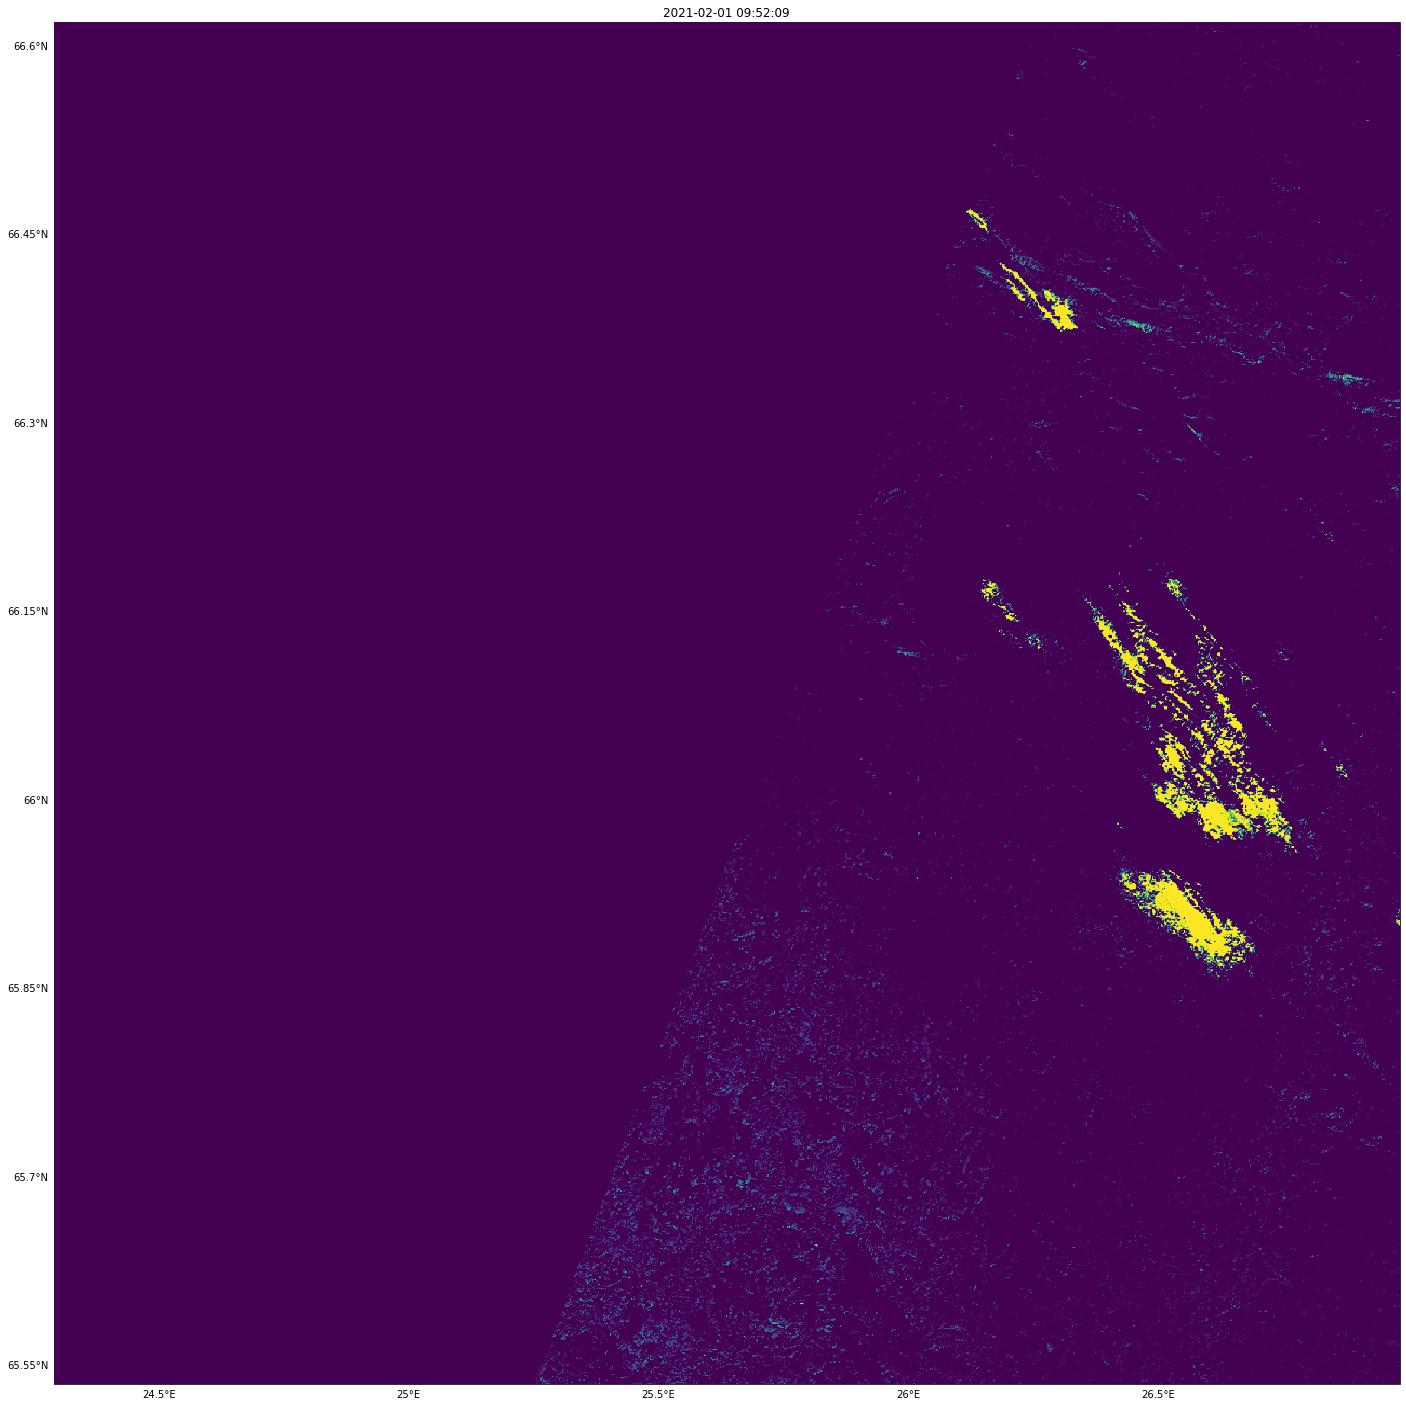

In [14]:
# show cloud mask products
response.plotImages( 'CLD.tif', alpha={ 'data' : 1.0, 'grid' : 0.0 } )

C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


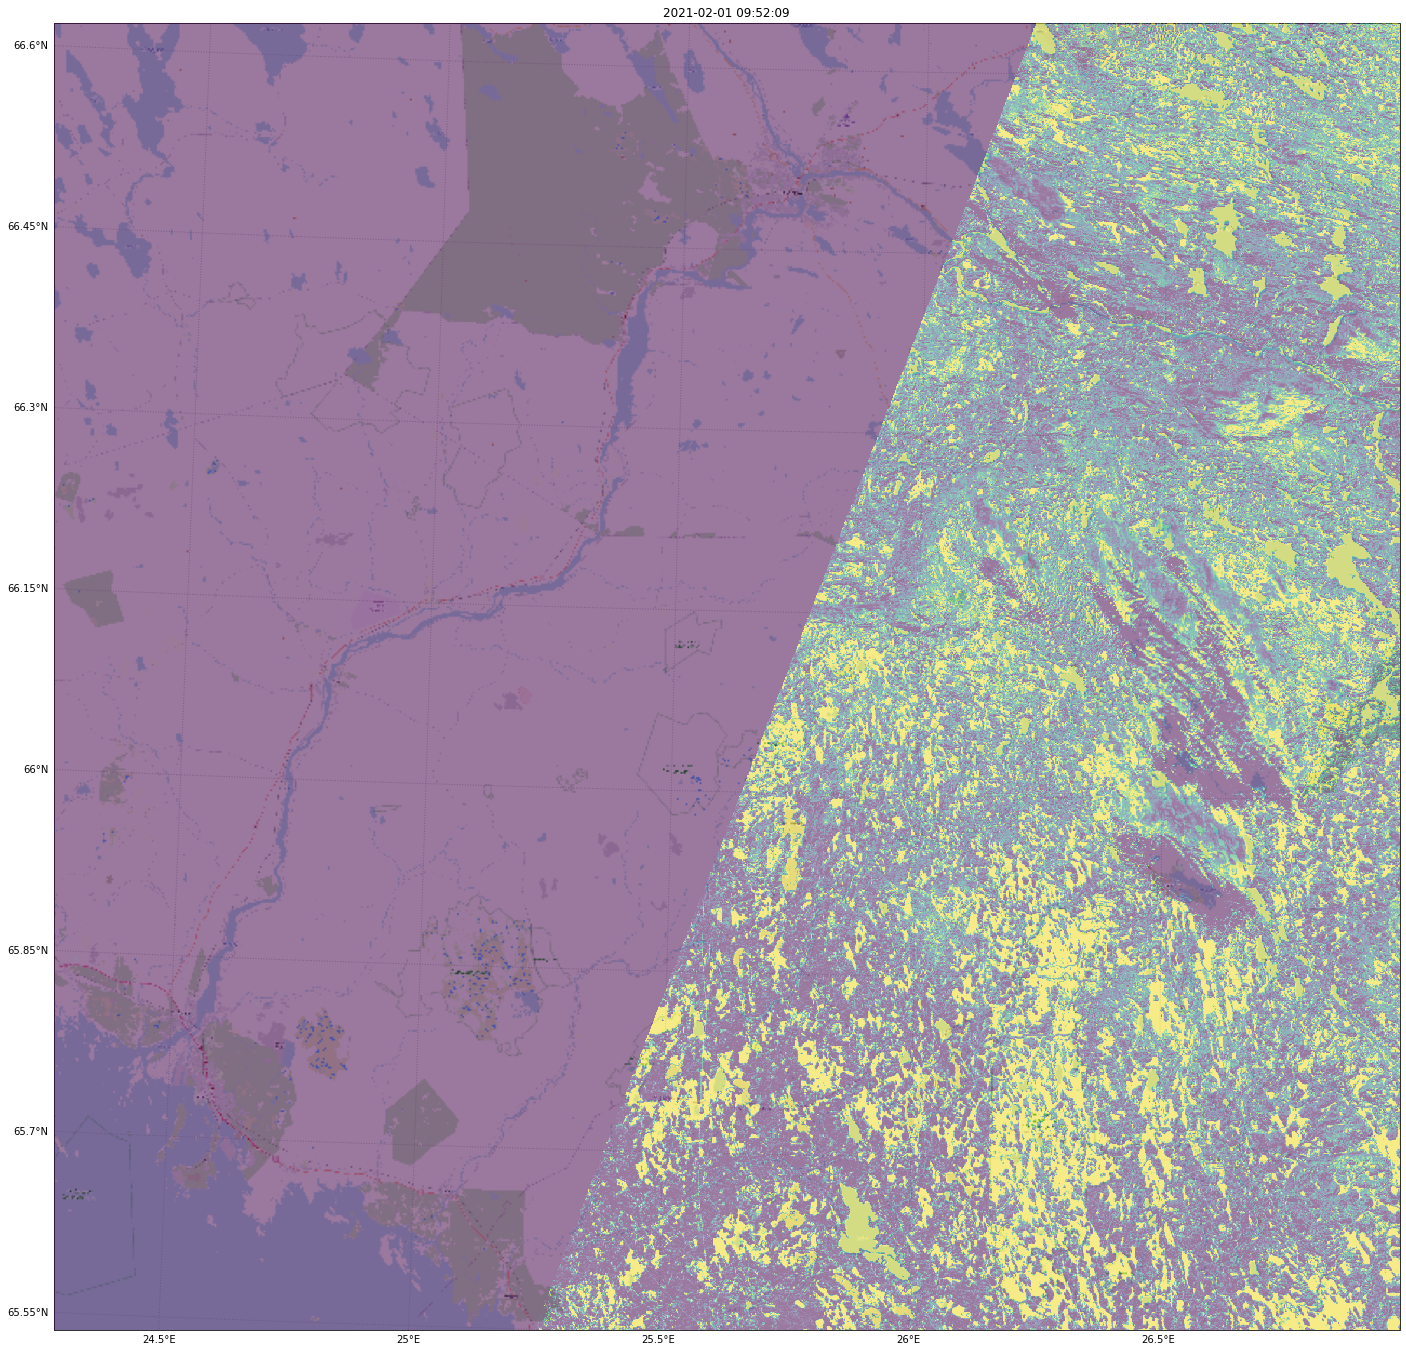

In [15]:
# show snow mask products
response.plotImages( 'SNW.tif', osm_zoom=11, alpha={ 'data' : 0.5, 'grid' : 0.5 } )

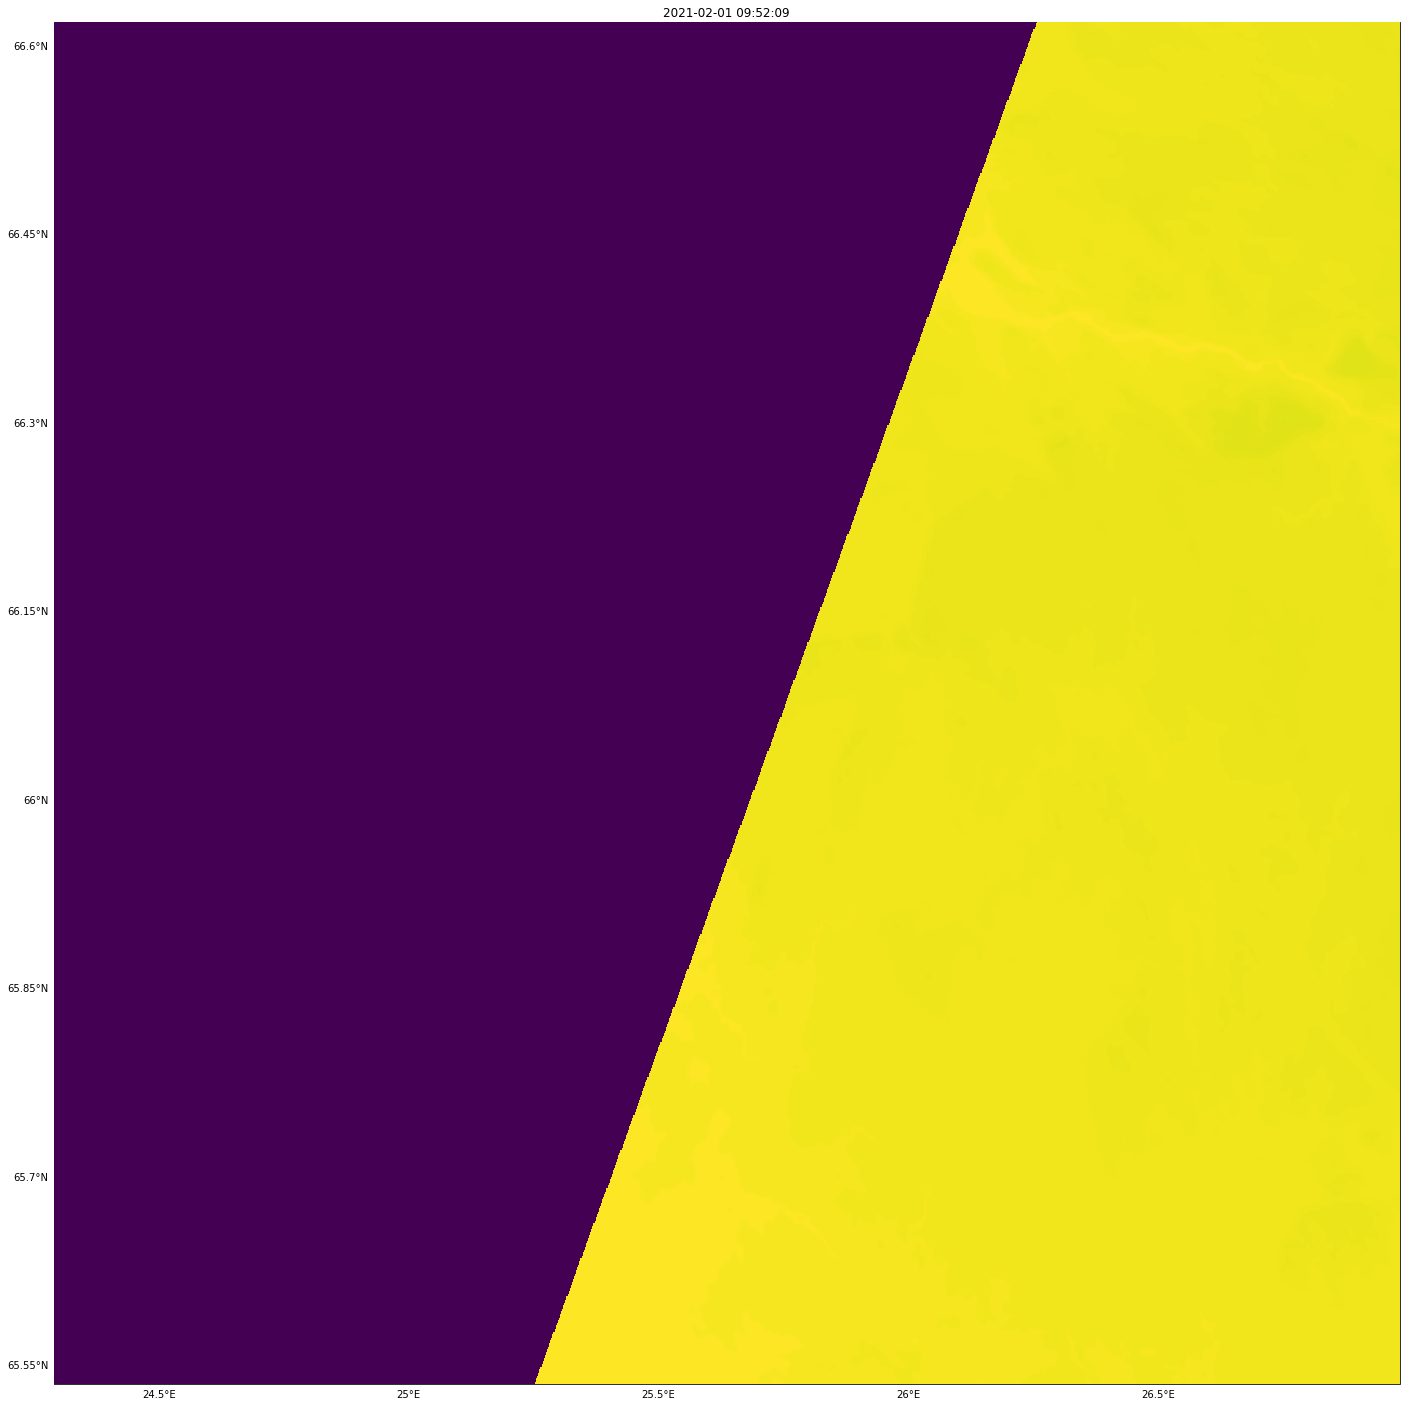

In [16]:
# show aerosol optical thickness products
response.plotImages( 'AOT.tif', alpha={ 'data' : 1.0, 'grid' : 0.0 } )

### _Plot Aerosol Optical Thickness image histogram_

In [17]:
# flatten 2nd aot image
row = response._df.iloc[ 0 ]
aot = row[ 'AOT.tif' ].flatten()

In [18]:
# stats of aerosol optical thickness
import numpy as np
import numpy.ma as ma

aot_mask = ma.masked_where(aot == 0, aot)
np.amin( aot_mask ), np.amax( aot_mask )

(193.0, 204.0)

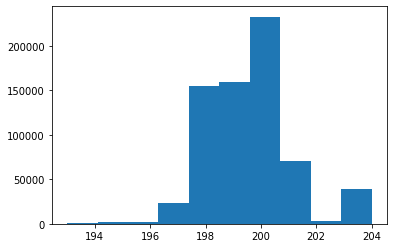

In [19]:
import matplotlib.pyplot as plt

# histogram of aot
plt.hist( aot_mask )
plt.show()